# Read and plot DTS data
This notebook shows how to read DTS data from a .csv file and plot it.

In [1]:
# load packages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime
import random
import scipy
from scipy.integrate import odeint
from scipy.integrate import ode, complex_ode
from scipy.optimize import minimize
from findiff import FinDiff
import matplotlib.pyplot as plt
from time import perf_counter
from skimage import feature
from tqdm import tqdm
from skimage.filters import meijering, sato, frangi, hessian
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from symfit import parameters, variables, sin, cos, Fit
import pickle
import math
from scipy.interpolate import UnivariateSpline
from PyAstronomy import pyaC
import get_temp_amplitude
import lmfit
from tg_solver import tg_solve
# import cv2

# matplotlib.use('TkAgg')
# %matplotlib qt
# %matplotlib widget

In [2]:
# Read temperature data
infile = '../data/DTS/temp_cal_valid_cable_rmnoise.csv'
df_temp = pd.read_csv(infile, index_col=0)
df_temp.columns = pd.to_datetime(df_temp.columns)
df_temp.head()

,2023-08-09 17:09:32.415,2023-08-09 17:14:32.521,2023-08-09 17:19:32.622,2023-08-09 17:24:32.751,2023-08-09 17:29:32.871,2023-08-09 17:34:33.023,2023-08-09 17:39:33.151,2023-08-09 17:44:33.281,2023-08-09 17:49:33.393,2023-08-09 17:54:33.510,...,2023-08-29 13:21:53.278,2023-08-29 13:26:53.872,2023-08-29 13:31:54.456,2023-08-29 13:36:55.019,2023-08-29 13:41:55.583,2023-08-29 13:46:56.141,2023-08-29 13:51:56.718,2023-08-29 13:56:57.291,2023-08-29 14:01:57.900,2023-08-29 14:02:08.202
-22.999,21.8724,21.9242,21.7593,22.0574,22.2256,22.5217,22.7067,22.8808,23.2244,23.5173,...,25.5453,25.3991,25.4547,25.4546,25.6803,25.7883,25.9772,25.8514,25.8928,26.1549
-22.745,21.8849,21.9424,21.7415,22.0645,22.2294,22.5077,22.7098,22.8978,23.2494,23.5068,...,25.5339,25.4029,25.4845,25.4733,25.6727,25.8092,25.9818,25.8577,25.9044,26.1569
-22.490,21.8829,21.9581,21.7719,22.0786,22.2661,22.4844,22.7420,22.8877,23.2459,23.5008,...,25.5144,25.4283,25.4984,25.5012,25.6936,25.8112,25.9707,25.8581,25.9104,26.0933
-22.236,21.9095,21.9571,21.7812,22.0970,22.2612,22.4886,22.7592,22.8818,23.2265,23.4932,...,25.5312,25.4563,25.5038,25.5070,25.7078,25.7885,25.9619,25.8641,25.9341,26.1819
-21.982,21.9441,21.9227,21.7831,22.0871,22.2620,22.5016,22.7392,22.8826,23.2373,23.5235,...,25.5722,25.4460,25.5155,25.5173,25.7258,25.8020,25.9593,25.8840,25.9210,26.2319


In [3]:
# Put temperature data, optical distances and sampling times into numpy arrays
temp_arr = df_temp.to_numpy().T # we want to have the time to be in the 0-axis to be consistent with DAS data
times = pd.to_datetime(df_temp.columns)
dists = df_temp.index.to_numpy()

In [4]:
# plot selected DTS data over time
# enter water at: 560m, exit water at 7565m
start_dist = 2820 # east ridge at 2820m optical distance
end_dist = 3150 # seafloor from ~3150m optical distance onward

start_time = times[0] #datetime.datetime(2023,8,9)
end_time = times[-1] #datetime.datetime(2023,8,30)

t_idx_start = np.argmin(np.abs(times-start_time))
t_idx_end = np.argmin(np.abs(times-end_time))
d_idx_start = np.argmin(np.abs(dists-start_dist))
d_idx_end = np.argmin(np.abs(dists-end_dist))

plot_arr = temp_arr[t_idx_start:t_idx_end, d_idx_start:d_idx_end]
plot_times = times[t_idx_start:t_idx_end]
plot_dists = dists[d_idx_start:d_idx_end]


In [5]:
# filter = scipy.signal.butter(1, 0.0111, 'hp', fs=5, output='sos', analog=False) # 5 represents 5 second sampling rate
# Band pass filter 
filtered_arr = scipy.ndimage.gaussian_filter(plot_arr, 10, axes=1)

startt = datetime.datetime(2023, 8, 25, 0)
endt = datetime.datetime(2023, 8, 26, 16)
startind_t = np.absolute(plot_times - startt).argmin()
endind_t = np.absolute(plot_times - endt).argmin()

# startind_d = np.absolute(plot_dists - 2940).argmin()
# endind_d = np.absolute(plot_dists - 3000).argmin()

startind_d = np.absolute(plot_dists - 2900).argmin()
endind_d = np.absolute(plot_dists - 3300).argmin()

filtered_arr = scipy.ndimage.gaussian_filter(filtered_arr[startind_t:endind_t, startind_d:endind_d], 1.2)
plot_times_zoomed = plot_times[startind_t:endind_t]
plot_times_zoomed_int = plot_times_zoomed.astype('int64')
plot_dists_zoomed = plot_dists[startind_d:endind_d]

# Detecting the amplitude of the waves

## Making my own contours

In [6]:
contour_values = np.linspace(0.55, 2.2, 100) # 0.55
contour_values_legend = []
for i in range(len(contour_values)): contour_values_legend.append(str(contour_values[i]) + "ºC")

contour_points = {}
contour_points_arr = np.empty((len(contour_values), len(plot_times_zoomed)))
contour_points_og = np.empty((len(contour_values), len(plot_times_zoomed)))
# np.empty((len(contour_values), len(filtered_arr[:, 1])))
cvi = 0

for cv in contour_values:
    avg_zero_crossings = 0
    nan_inds = []
    real_inds = []
    contour_points[cv] = {}
    contour_points[cv]['x'] = []
    contour_points[cv]['t'] = []
    for i in range(len(filtered_arr[:, 0])):
        xc = pyaC.zerocross1d(plot_dists_zoomed, filtered_arr[i, :] - cv)
        if(len(xc) == 1):
            real_inds.append(i)
            contour_points_arr[cvi, i] = xc.flatten().tolist()[0]
            contour_points[cv]['x'].extend(xc.flatten().tolist())
            contour_points[cv]['t'].extend(np.full(len(xc), plot_times_zoomed_int[i]).tolist())
        else:
            nan_inds.append(i)
            contour_points_arr[cvi, i] = float('NaN')
        avg_zero_crossings = avg_zero_crossings + len(xc)
    # print('Temp contour =', cv, 'avg of', avg_zero_crossings/len(filtered_arr[:, 0]), 'zero crossings')
    
    nan_inds = np.array(nan_inds)
    real_inds = np.array(real_inds)

    contour_points_og[cvi] = contour_points_arr[cvi]
    # print(np.all(np.diff(plot_times_zoomed_int[real_inds]) > 0))

    contour_points_arr[cvi][nan_inds] = np.interp(plot_times_zoomed_int[nan_inds], np.array(contour_points[cv]['t']), contour_points[cv]['x'])
    # f = scipy.interpolate.interp1d(plot_times_zoomed_int[real_inds], contour_points_arr[cvi][real_inds], kind= "slinear")
    # try: contour_points_arr[cvi][nan_inds] = f(plot_times[nan_inds])
    # except: print(nan_inds)
    # contour_points_arr[cvi] = np.interp(plot_times_zoomed.astype('int64'), np.array(contour_points[cv]['t']).astype('int64'), contour_points[cv]['x'])
    cvi = cvi + 1


# np.interp(xc, plot_dists_zoomed, filtered_arr[i, :])

## Plotting

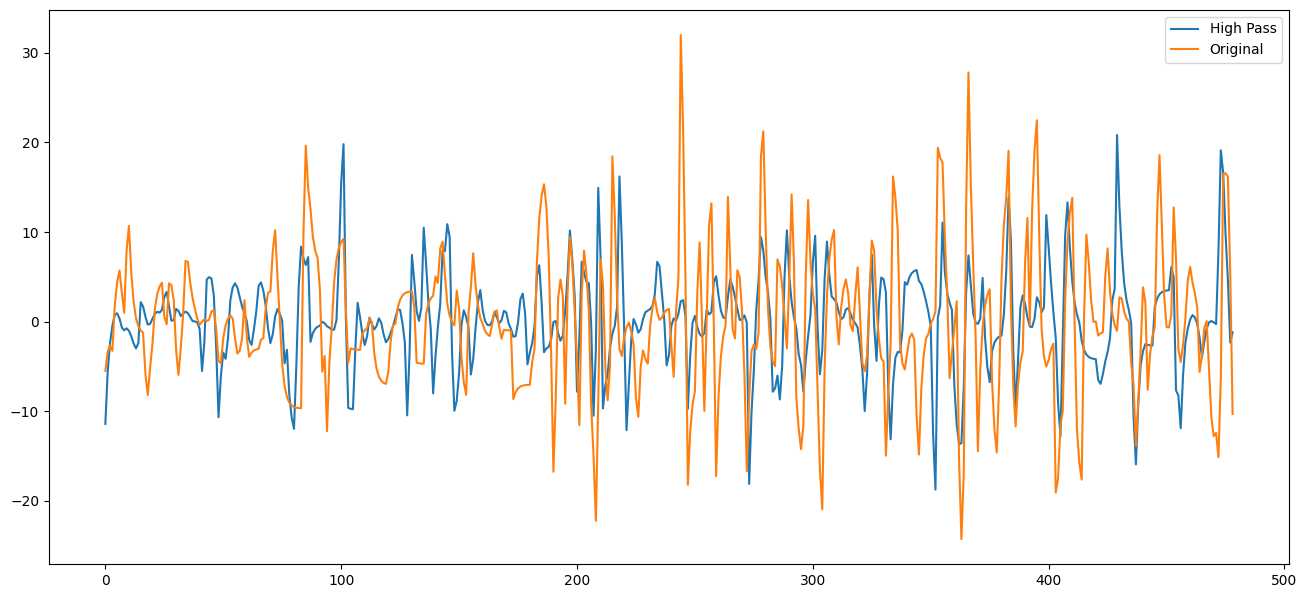

In [7]:
depths = np.empty(np.shape(contour_points_arr))
displacements = np.empty(np.shape(contour_points_arr))

filter = scipy.signal.butter(1, 0.5, 'hp', fs=5, output='sos', analog=False) # 5 represents 5 second sampling rate

for i in range(len(contour_points_arr[:, 0])):
    contours_high_pass = scipy.signal.sosfilt(filter, contour_points_arr[i, :] - np.median(contour_points_arr[i, :]))
    depths[i] = np.median(contour_points_arr[i, :])
    displacements[i] = contours_high_pass

i = 80 # np.absolute(depths - 3027).argmin()
# print(i)
contours_high_pass = scipy.signal.sosfilt(filter, contour_points_arr[i, :] - np.median(contour_points_arr[i, :]))

fig, ax = plt.subplots(figsize=(2.5*6.4,1.5*4.8))
ax.plot(displacements[i, :])
ax.plot(displacements[i - 70, :])
# ax.plot(contour_points_arr[i, :] - np.median(contour_points_arr[i, :]))
ax.legend(['High Pass', 'Original'])

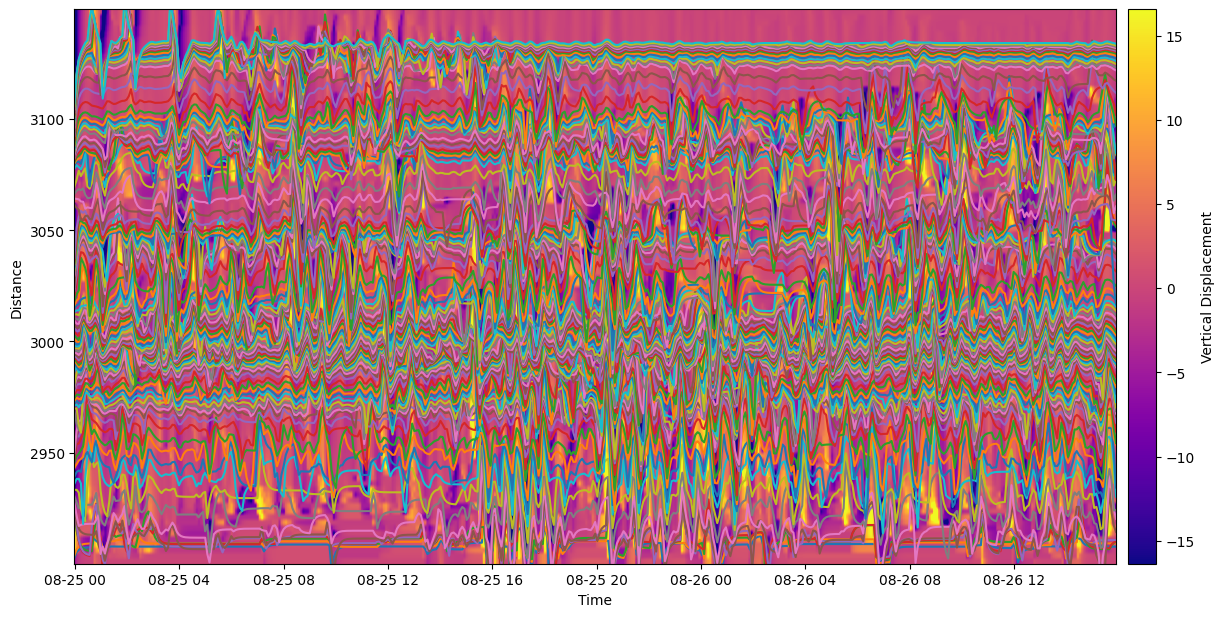

In [8]:

fig, ax = plt.subplots(figsize=(2.5*6.4,1.5*4.8))
for i in range(len(displacements[:, 0])): plt.plot(plot_times_zoomed, depths[i, :] + displacements[i, :])
im1 = ax.imshow(displacements, origin='lower',
           aspect='auto',
            extent=[plot_times_zoomed[0], plot_times_zoomed[-1],
                   plot_dists_zoomed[0], plot_dists_zoomed[-1]],
            cmap='plasma',
            vmin=np.percentile(displacements[~np.isnan(displacements)],1),
            vmax=np.percentile(displacements[~np.isnan(displacements)],99),
            )
ax.set_ylabel('Distance')
ax.set_xlabel('Time')
# plt.legend(contour_values_legend)

cbar = fig.colorbar(im1, pad=0.01)
cbar.set_label('Vertical Displacement')
plt.show()
# plt.plot(datetime.datetime(*contour_points[contour_values[0]]['t']), contour_points[contour_values[0]]['x'], '.')
# plt.plot(plot_times_zoomed[real_inds], contour_points_arr[0][real_inds], '.')
# print(interpf(plot_times_zoomed_int[nan_inds]))


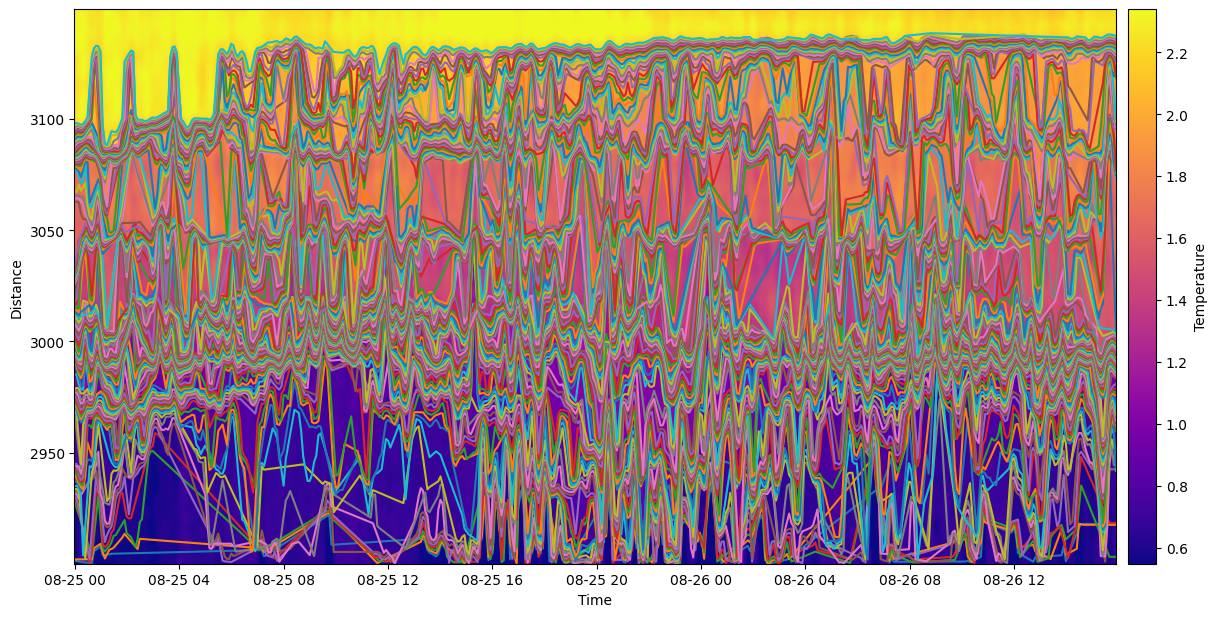

In [9]:
fig, ax = plt.subplots(figsize=(2.5*6.4,1.5*4.8))
im1 = ax.imshow(filtered_arr.T, origin='lower',
           aspect='auto',
            extent=[plot_times_zoomed[0], plot_times_zoomed[-1],
                   plot_dists_zoomed[0], plot_dists_zoomed[-1]],
            cmap='plasma',
            vmin=np.percentile(filtered_arr[~np.isnan(filtered_arr)],1),
            vmax=np.percentile(filtered_arr[~np.isnan(filtered_arr)],99),
            )
for i in range(len(contour_values)): plt.plot(plot_times_zoomed, contour_points_arr[i], '-')
# for i in range(len(contour_values)): plt.plot(contour_points[contour_values[i]]['t'], contour_points[contour_values[i]]['x'], '.')
# plt.contour(plot_times_zoomed, plot_dists_zoomed, filtered_arr.T, contour_values)

ax.set_ylabel('Distance')
ax.set_xlabel('Time')
# plt.legend(contour_values_legend)

cbar = fig.colorbar(im1, pad=0.01)
cbar.set_label('Temperature')
plt.show()

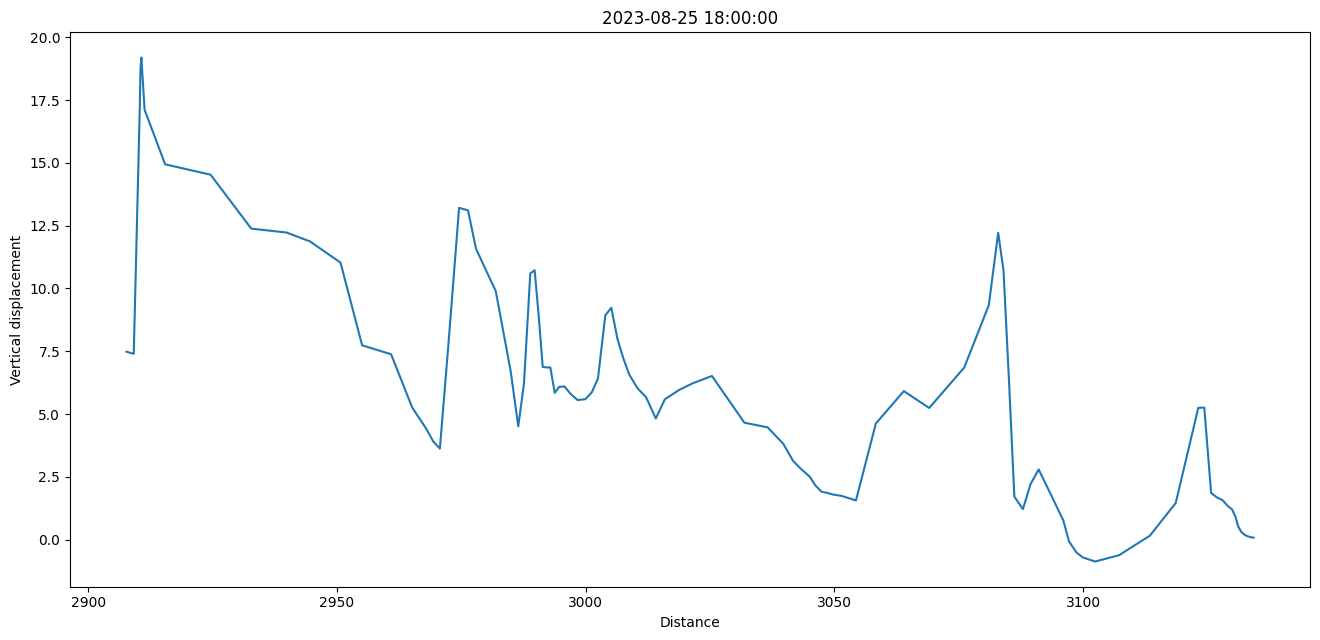

In [10]:
time_slice = datetime.datetime(2023, 8, 25, 18)
fig, ax = plt.subplots(figsize=(2.5*6.4,1.5*4.8))
ax.plot(depths[:, np.absolute(plot_times_zoomed - time_slice).argmin()], displacements[:, np.absolute(plot_times_zoomed - time_slice).argmin()])
ax.set_xlabel('Distance')
ax.set_ylabel('Vertical displacement')
ax.set_title(str(time_slice))
plt.show()

## Create TG formulation of problem

In [11]:
alpha = 1e-3
N = 1e-3
H = 400
time_idx = np.absolute(plot_times_zoomed - time_slice).argmin()
depths = depths - depths[0, time_idx]
z = depths[:, time_idx]
dz = z[1] - z[0]
U = 0 * z # (z/H)**3

d_dz = FinDiff(0, dz, 1)
d2_dz2 = FinDiff(0, dz, 2)
d2U_dz2 = d2_dz2(U)
d2mat = np.array(d2_dz2.matrix(U.shape).toarray())
c_test = 0.01
sol = []
ic = [0,1]
sol.append(ic)
r = ode(tg)
r.set_initial_value(ic, z[0])
r.set_f_params( (alpha,N,U,d2U_dz2,z,c_test) )
# for zz in z:
for zz in z[1:]:
    sol.append(r.integrate(zz))
sol=np.array(sol)

fig3, ax3 = plt.subplots(figsize=(2.5*6.4,1.5*4.8))
ax3 = plt.subplot()
ax3.plot(sol[:,0],z)
ax3.set_xlabel("Phi")
ax3.set_ylabel("Depth")
plt.show()

NameError: name 'tg' is not defined

In [ ]:
def tg2(y,z,alpha,N,U,Upp,all_z,c):
    ind = np.argmin(np.abs(all_z-z))
    coeff = alpha**2 - (N**2 - (U[ind]-c) * Upp[ind])/(U[ind]-c)**2
    return [y[1], coeff*y[0]]


In [ ]:
def tg2(y,z,alpha,N,U,Upp,all_z,c):
    ind = np.argmin(np.abs(all_z-z))
    coeff = alpha**2 - (N**2 - (U[ind]-c) * Upp[ind])/(U[ind]-c)**2
    return [y[1], coeff*y[0]]

def rootode(tg2, ic2, z, arglist): return odeint(tg2, [ic2,1], z,args=( arglist ))

def tg_solve(alpha, z, N, H, U, ic, c_test):
    dz = z[1] - z[0]
    d_dz = FinDiff(0, dz, 1)
    d2_dz2 = FinDiff(0, dz, 2)
    d2U_dz2 = d2_dz2(U)
    d2mat = np.array(d2_dz2.matrix(U.shape).toarray())

    f = lambda ic2: rootode(tg2, ic2, z, (alpha,N,U,d2U_dz2,z,c_test))[-1, 0]
    ic_sol = scipy.optimize.bisect(f, -100, 100)
    # ic_sol = ic[0]
    
    sol = odeint(tg2, [ic_sol, ic[1]], z,args=( (alpha,N,U,d2U_dz2,z,c_test) ))

    return odeint(tg2, [ic_sol,ic[1]], z,args=( (alpha,N,U,d2U_dz2,z,c_test) )), [ic_sol, ic[1]]

-7.85348390036944
-4.007746931164036
-4.007746931164036
-4.007746931164036
-4.024919690017725
-4.007627727899887
-4.007879737535802
-4.00772769716724
-4.007764358631505
-4.00805793475314
-4.0077997428582535
-4.007742361586963
-4.007746931164036
-4.007746931164036
-4.007746931164036
-4.007746931164036
-4.007746931164036
-4.007746931164036
-4.007746931164036
-4.007746931164036
-4.007746931164036
-4.007746931164036
-4.007746931164036
-4.007746931164036
-4.007746931164036
-4.007746931164036
-4.007746931164036
-4.007746931164036
-4.007746931164036
-4.007746931164036
-4.007746931164036
-4.007746931164036
-4.007746931164036
-4.007746931164036
-4.007746931164036
-4.007746931164036
-4.007746931164036
-4.007746931164036
-4.007746931164036
-4.007746931164036
-4.007746931164036
-4.007746931164036
-4.007746931164036
-4.007746931164036
-4.007746931164036
-4.007746931164036
-4.007746931164036
-4.007746931164036
-4.007746931164036
-4.007746931164036
-4.007746931164036
-4.007746931164036
-4.00774693116

/var/folders/0w/3nhprhs523j29wbz2w1cnrl00000gn/T/ipykernel_26310/2933223424.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  def rootode(tg2, ic2, z, arglist): return odeint(tg2, [ic2,1], z,args=( arglist ))


77.59186921942813


/var/folders/0w/3nhprhs523j29wbz2w1cnrl00000gn/T/ipykernel_26310/2933223424.py:20: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol = odeint(tg2, [ic_sol, ic[1]], z,args=( (alpha,N,U,d2U_dz2,z,c_test) ))
/var/folders/0w/3nhprhs523j29wbz2w1cnrl00000gn/T/ipykernel_26310/2933223424.py:22: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  return odeint(tg2, [ic_sol,ic[1]], z,args=( (alpha,N,U,d2U_dz2,z,c_test) )), [ic_sol, ic[1]]


4.0318617480622265
-6.76899928442225
-4.0695648138338925
-4.012800843337061
-4.010255633691884
-4.008941064616067
-4.008313919540285
-4.008001668260874
-4.007851038305432
-4.007746931164036


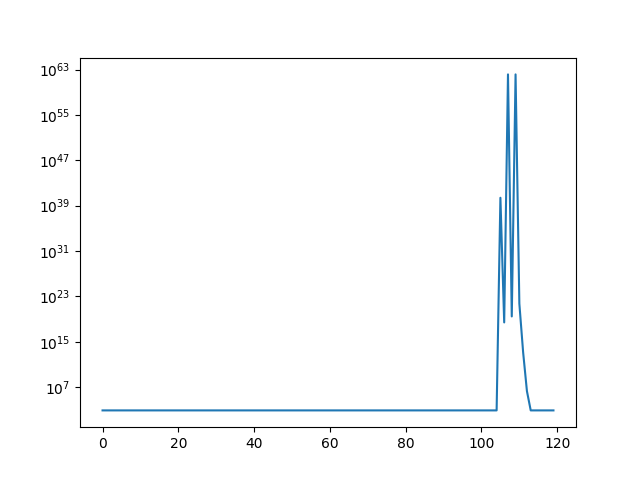

-4.007746931164036
[0.0, 1.0]


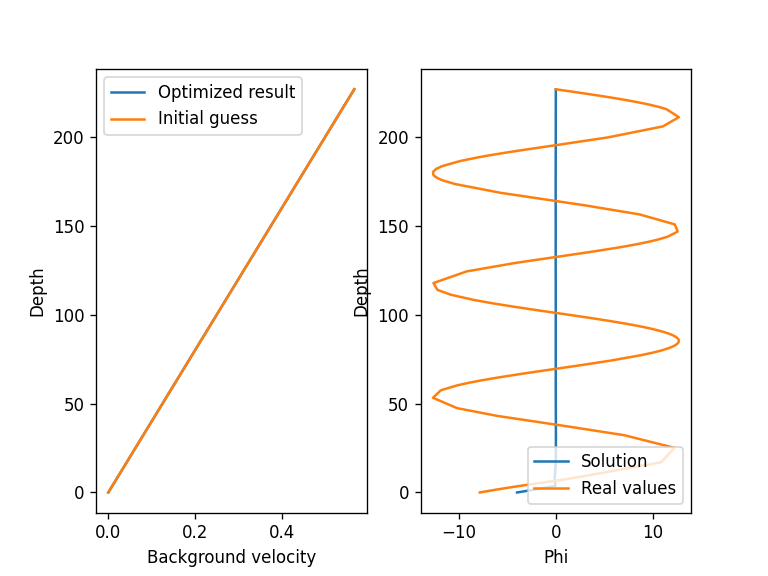

In [ ]:
time_idx = np.absolute(plot_times_zoomed - time_slice).argmin()
alpha = 1e-3
N = 1e-3
H = 400
depths = np.array(depths - depths[0, time_idx])
z = np.array(depths[:, time_idx])

displacements[:, int(time_idx)] = tg_solve(alpha, z, N, H, np.zeros(len(z)), [0, 1], 0.01)[0][:, 0]
U_guess = z/H * np.ones(len(z)) # np.random.rand(len(z)) * 0.5 - 0.25 # [-1e1, 1e1, -10, 10, -10] # (z/H)**3

param_names = ["a" + str(int(i)) for i in range(len(U_guess))]
bnds = []
for i in range(len(U_guess)):
    bnds.append((-1, 1))
U_guess = np.append(U_guess, [0, 1])
param_names = np.append(param_names, 'ic0')
param_names = np.append(param_names, 'ic1')
bnds.append((-1, 1))
ic = [0, 1] # [displacements[0, time_idx], -5]
c_test = 0.01

res_list = []

def res_disps(params, z, N, H, c_test, displacements, depths, time_idx, ic):
    U = [params[name].value for name in param_names]
    ic[1] = params['ic1'].value
    f = lambda U: tg_solve(alpha, z, N, H, U, ic, c_test)[:, 0]
    U_opt = U[0:-2]
    sol = tg_solve(alpha, z, N, H, np.array(U_opt), ic, c_test)
    ic_sol = sol[1]
    sol = sol[0]
    # print(np.linalg.norm(sol[:, 0] - displacements[:, time_idx], ord=2))
    res_list.append(np.linalg.norm(sol[:, 0] - displacements[:, time_idx], ord=1))

    return np.concatenate((np.array([sol[0:2, 0] - displacements[0:2, time_idx]]).flatten(), (sol[:, 0] - displacements[:, time_idx]))) * 1e-10


params = lmfit.Parameters()
for name, value in zip(param_names, U_guess):
    params.add(name, value=value, min=-1.1, max=1.1)

minimizer = lmfit.Minimizer(res_disps, params, fcn_args=(z, N, H, c_test, displacements, depths, time_idx, ic))
result = minimizer.minimize(method='leastsq', max_nfev=1000)
# lmfit.report_fit(result)

U_opt = [result.params[name].value for name in param_names]
ic[0] = result.params['ic0'].value
ic[1] = result.params['ic1'].value

fig2 = plt.subplots()
plt.plot(res_list)
plt.yscale("log")
plt.show()


sol = tg_solve(alpha, z, N, H, np.array(U_opt), ic, c_test)

fig, ax = plt.subplots(1, 2, dpi=120)
print(ic)
ax[0].plot(U_opt[0:100],z)
ax[0].plot(U_guess[0:-2],z)
ax[0].set_xlabel('Background velocity')
ax[0].set_ylabel('Depth')
ax[0].legend(['Optimized result', 'Initial guess'])
ax[1].plot(sol[0][:,0],z)
# ax[1].plot(res_disps(U_opt, z, N, H, c_test, displacements, depths, time_idx), z)
ax[1].plot(displacements[:, time_idx], z)
ax[1].set_xlabel("Phi")
ax[1].set_ylabel("Depth")
# ax[1].set_xlim([-10, 10])
ax[1].legend(['Solution', 'Real values'])
plt.show()